In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse
from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection
import sqlite3

import joblib 
import os
import datetime as dt
from collections import Counter, defaultdict
import math
import re
import datetime as dt
import time
import csv
import os

import warnings
warnings.filterwarnings("ignore")

##################################
##################################

from xgboost import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, normalized_mutual_info_score, classification_report, \
                            precision_recall_curve, auc, roc_curve

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

## Applying TFIDF WEIGHTED W2V

In [2]:
tfidf_weighted_w2v = pd.read_csv("models/01_nlp/tfidf_weight_w2v3000.csv")
tfidf_weighted_w2v = tfidf_weighted_w2v.drop(["Unnamed: 0"], axis=1)
print(tfidf_weighted_w2v.shape)
tfidf_weighted_w2v.head(1)

(3000, 193)


,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,38.161535,-16.883424,27.364944,-2.225619,6.019804,-9.301675,-1.573213,1.481994,-7.730493,-2.612193,...,20.356704,-33.651369,4.493593,-2.982234,-11.982838,12.24958,18.157573,-10.208319,16.406053,12.979552


In [3]:
all_features = pd.read_csv("data/04_all_features.csv")
all_features = all_features.drop(["Unnamed: 0"], axis=1)
all_features = all_features[:3000]
print(all_features.shape)
all_features.head(1)

(3000, 49)


,id,qid1,qid2,question1,question2,is_duplicate,cleaned_q1,cleaned_q2,freq_qid1,freq_qid2,...,dist_braycurtis,dist_chebyshev,dist_correlation,dist_hamming,dist_jaccard,dist_kulsinski,dist_rogerstanimoto,dist_russellrao,dist_sokalmichener,dist_yule
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,...,0.117393,0.112668,0.00684,1.0,1.0,0.860943,-0.670791,0.895868,-0.670791,0.233231


In [4]:
tfidf_weighted_w2v['id'] = all_features["id"]
X = all_features.merge(tfidf_weighted_w2v, on='id',how='left')
X = X.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'cleaned_q1', 'cleaned_q2'], axis=1)
print(X.shape)
X.head(1)

(3000, 234)


,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,...,20.356704,-33.651369,4.493593,-2.982234,-11.982838,12.24958,18.157573,-10.208319,16.406053,12.979552


In [5]:
X = X.replace(np.nan, 0)
X.reset_index()

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

X = clean_dataset(X)

cols = list(X.columns)
X = pd.DataFrame(np.array(X.values,dtype=np.float64),columns=cols)

In [6]:
Y = X['is_duplicate']
X = X.drop(['is_duplicate'], axis=1)

# Random sampling
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) 
# x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2)

# Data shape
print("Y: ", Y.shape)
print("X: ", X.shape)
print("-"*50)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print("Finite value: ", np.any(np.isfinite(x_train)))
print("NaN value: ", np.any(np.isnan(x_train)))

Y:  (2980,)
X:  (2980, 233)
--------------------------------------------------
(2384, 233) (2384,)
(596, 233) (596,)
Finite value:  True
NaN value:  False


In [7]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6178691275167785 Class 1:  0.3821308724832215
---------- Distribution of output variable in train data ----------
Class 0:  0.36577181208053694 Class 1:  0.36577181208053694


In [4]:
def BestMLAlgo(nlp_model, x_train, x_test, y_train, y_test):
    """Identify best Algo on given dataset"""
    from prettytable import PrettyTable
    
    table = PrettyTable()
    table.field_names = ["Vect", "Model", "Accuracy", "Precision", "Recall", "AUCScore", "AVG TPR", "AVG FPR", "AvgThresh", "F1Score", "Log loss"]
                        
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import xgboost
    from sklearn import svm
    
    classificatino_models = {
        'kNN': KNeighborsClassifier(),
        'Log. Reg.': LogisticRegression(),
        'SVM Linear': svm.SVC(probability=False),
        'SVM Non-linear': svm.SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boost': GradientBoostingClassifier(),
        'Ada Boost': AdaBoostClassifier(),
        'xgboost': xgboost.XGBClassifier(),
    }
    
    from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix,\
                                log_loss

    for model_name, model in classificatino_models.items():
        model.fit(x_train, y_train)
        x_pred_test = model.predict(x_test)

        # Performance metrics
        tn, fp, fn, tp = confusion_matrix(y_test, x_pred_test).ravel()
        accuracy    = round((tp+tn)/(tp+tn+fp+fn), 2)
        precision   = round((tp/(tp+fp)), 2)
        specificity = round((tn/(fp+tn)), 2)
        error_rate  = round(((fp+fn)/(tp+tn+fp+fn)), 2)
        recall      = round((tp/(tp+fn)), 2)
        f1_score    = round((2*recall*precision)/(recall+precision), 2)
        loss = round(log_loss(y_test, x_pred_test, eps=1e-15), 2)

        try:
            fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1], pos_label=1)
            fpr_avg = round(sum(fpr)/len(fpr), 2)
            tpr_avg = round(sum(tpr)/len(tpr), 2)
            threshold_avg = round(sum(thresholds)/len(thresholds), 2)
            auc_score = round(auc(fpr, tpr), 2)    
            table.add_row([nlp_model, model_name,accuracy, precision, recall, auc_score, tpr_avg, fpr_avg, threshold_avg, f1_score, loss])
        except:
            table.add_row([nlp_model, model_name,accuracy, precision, recall, "", "", "", "", f1_score, loss])
    print(table)

In [9]:
BestMLAlgo("TFIDF AvgW2V", x_train, x_test, y_train, y_test)

[01:46:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+--------------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
|     Vect     |     Model      | Accuracy | Precision | Recall | AUCScore | AVG TPR | AVG FPR | AvgThresh | F1Score | Log loss |
+--------------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| TFIDF AvgW2V |      kNN       |   0.69   |    0.61   |  0.67  |   0.73   |   0.57  |   0.4   |    0.71   |   0.64  |  10.78   |
| TFIDF AvgW2V |   Log. Reg.    |   0.76   |    0.72   |  0.65  |   0.82   |   0.68  |   0.3   |    0.44   |   0.68  |   8.46   |
| TFIDF AvgW2V |   SVM Linear   |   0.73

#### CONCLUSION
* Best model is xgboost on TFIDF AvgW2V 

## Standardization 

In [10]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_std = scale.fit_transform(X)

# Random sampling
x_train_std, x_test_std, y_train, y_test = train_test_split(X_std, Y, test_size=0.2) 

In [11]:
BestMLAlgo("TFIDF AvgW2V", x_train, x_test, y_train, y_test)

[01:47:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+--------------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
|     Vect     |     Model      | Accuracy | Precision | Recall | AUCScore | AVG TPR | AVG FPR | AvgThresh | F1Score | Log loss |
+--------------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| TFIDF AvgW2V |      kNN       |   0.52   |    0.38   |  0.35  |   0.48   |   0.44  |   0.45  |    0.71   |   0.36  |  16.46   |
| TFIDF AvgW2V |   Log. Reg.    |   0.54   |    0.34   |  0.2   |   0.47   |   0.46  |   0.49  |    0.4    |   0.25  |  16.05   |
| TFIDF AvgW2V |   SVM Linear   |   0.61

#### CONCLUSION
* Standarddiztion is not good as compared

## Every feature except NLP vect

In [5]:
x = all_features.drop(['id', 'qid1', 'qid2', 'question1', 'question2', 'cleaned_q1', 'cleaned_q2'], axis=1)

x = x.replace(np.nan, 0)
x.reset_index()

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

x = clean_dataset(x)

cols = list(x.columns)
x = pd.DataFrame(np.array(x.values,dtype=np.float64),columns=cols)

y = x["is_duplicate"]

x = x.drop(["is_duplicate"], axis=1)

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2) 

# print(x_tr.shape, " ", x_te.shape, " ", y_tr.shape, " ", y_te.shape)
# x.head(1)

In [6]:
BestMLAlgo("NONE", x_tr, x_te, y_tr, y_te)

[19:42:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| Vect |     Model      | Accuracy | Precision | Recall | AUCScore | AVG TPR | AVG FPR | AvgThresh | F1Score | Log loss |
+------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| NONE |      kNN       |   0.73   |    0.66   |  0.58  |   0.78   |   0.55  |   0.31  |    0.71   |   0.62  |   9.39   |
| NONE |   Log. Reg.    |   0.79   |    0.73   |  0.71  |   0.87   |   0.69  |   0.23  |    0.48   |   0.72  |   7.24   |
| NONE |   SVM Linear   |   0.74   |    0.66   |  0.68  |          |         |  

In [7]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
x_std = scale.fit_transform(x)

# Random sampling
x_train_std, x_test_std, y_train, y_test = train_test_split(x_std, y, test_size=0.2) 

In [8]:
BestMLAlgo("NONE", x_tr, x_te, y_tr, y_te)

[19:44:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| Vect |     Model      | Accuracy | Precision | Recall | AUCScore | AVG TPR | AVG FPR | AvgThresh | F1Score | Log loss |
+------+----------------+----------+-----------+--------+----------+---------+---------+-----------+---------+----------+
| NONE |      kNN       |   0.73   |    0.66   |  0.58  |   0.78   |   0.55  |   0.31  |    0.71   |   0.62  |   9.39   |
| NONE |   Log. Reg.    |   0.79   |    0.73   |  0.71  |   0.87   |   0.69  |   0.23  |    0.48   |   0.72  |   7.24   |
| NONE |   SVM Linear   |   0.74   |    0.66   |  0.68  |          |         |  

## Applying Xgboost

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## Worst model

Log loss on Test Data using Random Model 0.8553870546067108


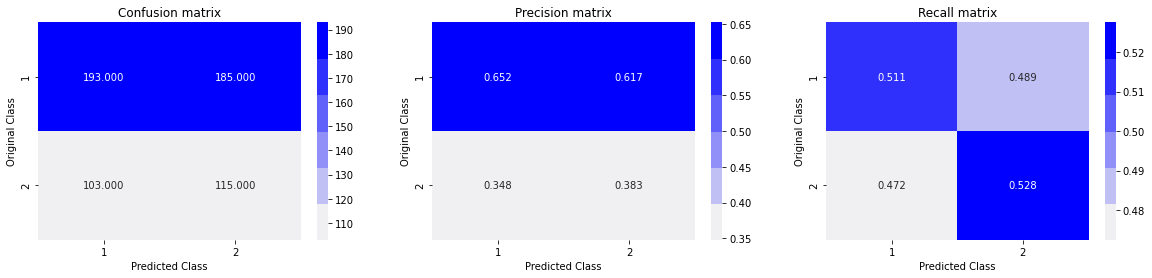

In [10]:
def worst_model():
    # we need to generate 9 numbers and the sum of numbers should be 1
    # one solution is to genarate 9 numbers and divide each of the numbers by their sum
    # ref: https://stackoverflow.com/a/18662466/4084039
    # we create a output array that has exactly same size as the CV data
    test_len = len(y_test)
    predicted_y = np.zeros((test_len,2))
    for i in range(test_len):
        rand_probs = np.random.rand(1,2)
        predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

    predicted_y =np.argmax(predicted_y, axis=1)
    plot_confusion_matrix(y_test, predicted_y)

worst_model()

#### CONCLUSION
* Since radom/worst case model gives us log loss = 0.84</br>
  therefore; best model should be less than 0.84

In [13]:
def xgboost_classifier(nlp_algo, ml_algo, X_train, Y_train, X_test, Y_test):
    import random
    from prettytable import PrettyTable
    
    table = PrettyTable()
    table.field_names = ["NLP algo", "ML_algo", "Train logloss", "Test logloss"] 
    
#     params_dict = [{"max_depth":  np.array([3, 6, 9, 12, 15]),
#               "learning_rate": np.array([0.01, 0.05, 0.1]),
#               "n_estimators": np.array([20, 35, 50, 70, 100]),
#               "min_child_weight": np.array(range(2, 8+1)),
#               "gamma": np.array([10 ** x for x in range(-5, 2)]),
#                    }]

    params_dict = [{'gamma': [1e-05],
                    'learning_rate': [0.01],
                    'max_depth': [3], 
                    'min_child_weight': [2],
                    'n_estimators': [20]}]


    
    
    xgb_optimal =  XGBClassifier()

    grid = GridSearchCV(estimator=xgb_optimal, 
                        param_grid=params_dict, 
                        scoring=log_loss, n_jobs=6, cv=3,
                        return_train_score=True)

    grid_result = grid.fit(X_train, Y_train)

    print("Optimal Parameters : ", grid_result.best_estimator_.get_params())
    
    # Prediction on training and test set using optimal classifier
    logProb_train = grid.predict_proba(X_train)
    logProb_test = grid.predict_proba(X_test)
    pred_train = np.argmax(logProb_train, axis =1)
    pred_test = np.argmax(logProb_test, axis =1)
    
    train_logloss = log_loss(Y_train, pred_train, labels=grid.classes_, eps=1e-15)
    test_logloss = log_loss(Y_test, pred_test, labels=grid.classes_, eps=1e-15)
    
    print("Train log loss: ", train_logloss) 
    print("Test log loss: ", test_logloss)
    
    print("Training Confusion Matrix")
    plot_confusion_matrix(y_train, pred_train)
    print('\n\n')

    print("Test Confusion Matrix")
    plot_confusion_matrix(y_test, pred_test)
    
    # Classification report 
    print(classification_report(Y_test, pred_test))
            
    grid_param = grid_result.best_estimator_.get_params()
    table.add_row([nlp_model, ml_algo, train_logloss, test_logloss])
    print("-"*50)
    print(table)
    return grid

[19:19:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimal Parameters :  {'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 1e-05, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 2, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 20, 'n_jobs': 4, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Train log loss:  6.896221768432546
Test log loss:  7.41779355304

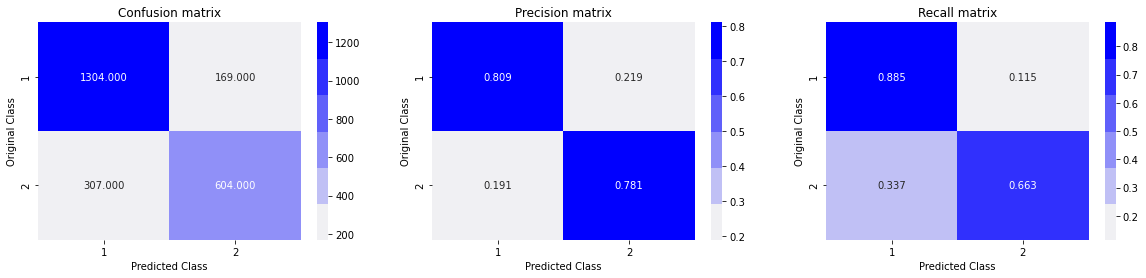




Test Confusion Matrix


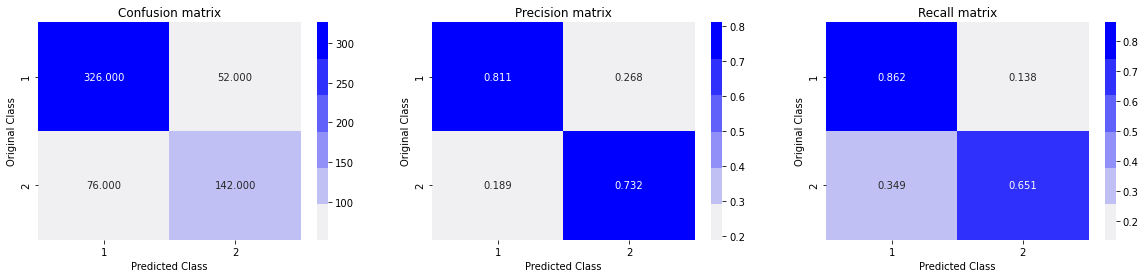

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       378
         1.0       0.73      0.65      0.69       218

    accuracy                           0.79       596
   macro avg       0.77      0.76      0.76       596
weighted avg       0.78      0.79      0.78       596

--------------------------------------------------
+---------------+---------+-------------------+-------------------+
|    NLP algo   | ML_algo |   Train logloss   |    Test logloss   |
+---------------+---------+-------------------+-------------------+
| TFIDF AVG W2V | XGBOOST | 6.896221768432546 | 7.417793553045198 |
+---------------+---------+-------------------+-------------------+


In [14]:
nlp_model = "TFIDF AVG W2V"
ml_model = "XGBOOST"
model = xgboost_classifier(nlp_model, ml_model, x_train, y_train, x_test, y_test)

In [16]:
joblib.dump(model, "models/TfidfAvgW2V_XGBOOST.joblib")

['models/TfidfAvgW2V_XGBOOST.joblib']